In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import sys

sys.path += ['../']

from src.utils_network import generate_network
from src.utils_model import initialize_model
from src.simulate import update_opinions, rmsd_from_truth, score_opinion_updates

In [2]:
from scipy import sparse

In [15]:
def update_opinions_2(Xa, Xe, eps_a, eps_e, alpha_e, tau, A):
    Na = Xa.shape[0]
    X_all = np.hstack([Xa, Xe])
    Xe = Xe[:, np.newaxis]
    eps_all = np.hstack([eps_a, eps_e])[:, np.newaxis]
    eps_e = eps_e[:, np.newaxis]

    # TODO:
    # - is it possible to make it faster? E.g., matrix formalism?
    # - manage divisions by 0

    # compute if pairwise differences of opinions under the confidence
    delta_opinions_thresholded = sparse.csr_matrix(np.abs(np.subtract.outer(X_all, X_all)) \
                                               <= eps_all).astype(int)
    
    # update Xa
    delta_opinions_thresholded_neigs = delta_opinions_thresholded.multiply(A)
    #Xa_new = delta_opinions_thresholded_neigs * X_all[:, np.newaxis] / delta_opinions_thresholded_neigs.sum(axis=1)
    #Xa_new = np.asarray(Xa_new).flatten()[:Na]
    Xa_new = np.asarray(delta_opinions_thresholded_neigs * X_all[:, np.newaxis]).flatten()
    n_neigs = np.asarray(delta_opinions_thresholded_neigs.sum(axis=1)).flatten()
    Xa_new = np.where(n_neigs == 0, X_all, Xa_new / n_neigs)
    Xa_new = Xa_new[:Na]
    
    
    
    # update Xe
    delta_opinions_thresholded = delta_opinions_thresholded[Na:, Na:]
    Xe_new = np.asarray(delta_opinions_thresholded * Xe / delta_opinions_thresholded.sum(axis=1))
    Xe_new = np.where((np.abs(Xe_new - tau) <= eps_e),
                      eps_e * tau + (1 - eps_e) * Xe_new,
                      Xe_new).flatten()
    

    
    
    
    
    """
    # update Xa
    delta_opinions_thresholded = sparse.csr_matrix(np.abs(np.subtract.outer(X_all, X_all)) \
                                               <= eps_all[:, np.newaxis]).astype(int)
    delta_opinions_thresholded_neigs = delta_opinions_thresholded.multiply(A)
    Xa_new = delta_opinions_thresholded_neigs * X_all[:, np.newaxis] / delta_opinions_thresholded_neigs.sum(axis=1)
    Xa_new = np.asarray(Xa_new).flatten()[:Na]
    
    # update Xe
    delta_opinions_thresholded = delta_opinions_thresholded[Na:, Na:]
    Xe_new = delta_opinions_thresholded * Xe[:, np.newaxis] / np.asarray(delta_opinions_thresholded.sum(axis=1))
    
    Xe_new = np.where((np.abs(Xe_new - tau) <= eps_e[:, np.newaxis]), 
                     alpha_e[:, np.newaxis] * tau + (1 - alpha_e[:, np.newaxis]) * Xe_new,
                     Xe_new)
    
    Xe_new = np.asarray(Xe_new).flatten()
    """
    
    return Xa_new, Xe_new


### Tests

In [4]:
RNG = np.random.RandomState(42)

In [16]:
# set input params
N = 1000
frac_experts = 0.1
tau = 0.9

Ne = int(N * frac_experts)
Na = N - Ne

# generate syntetic network
network_params = 'ER_20'
A = generate_network(N, Ne, network_params, seed=RNG)

# initialize opinions and confidences
model_param_dict = {
    'init_opinions' : {'distrib' : 'uniform'},
    'init_confidence' : {'distrib' : 'const', 'confidence' : 0.3},
    'init_alpha_experts' : {'distrib' : 'const', 'alpha' : 0.2}
}
init_opinions_params = 'uniform'
init_confidence_params = 'const_0.2'
init_alpha_experts_params = 'const_0.2'
Xa, Xe, eps_a, eps_e, alpha_e = initialize_model(Na, Ne, init_opinions_params, 
                                                 init_confidence_params, init_alpha_experts_params, seed=RNG)


In [17]:
%%timeit
Xa_new, Xe_new = update_opinions(Xa, Xe, eps_a, eps_e, alpha_e, tau, A)

97.3 ms ± 7.56 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
%%timeit
Xa_new, Xe_new = update_opinions_2(Xa, Xe, eps_a, eps_e, alpha_e, tau, A)

20.3 ms ± 259 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
Xa_new, Xe_new = update_opinions(Xa, Xe, eps_a, eps_e, alpha_e, tau, A)

In [20]:
Xa_new_2, Xe_new_2 = update_opinions_2(Xa, Xe, eps_a, eps_e, alpha_e, tau, A)

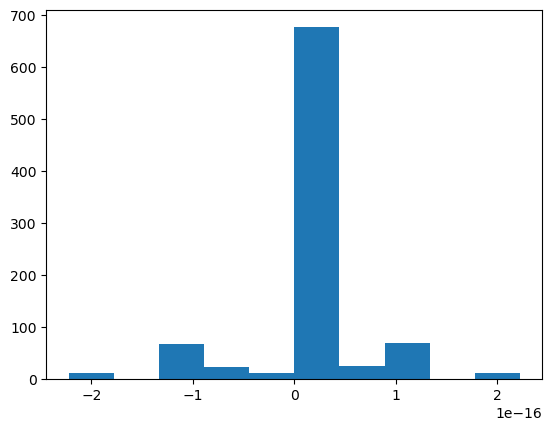

In [21]:
plt.hist(Xa_new - np.asarray(Xa_new_2).flatten());

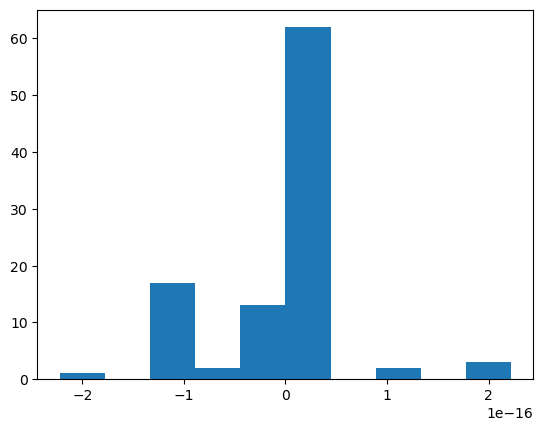

In [22]:
plt.hist(Xe_new - Xe_new_2);